In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset_anuka.zip to dataset_anuka.zip


In [2]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['dataset_anuka.zip']), 'r')
data.extractall()

In [3]:
import os

In [4]:
dataset_anuka_dir = '/content/dataset_anuka'

In [5]:
import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K

from keras import optimizers

In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 3, activation="relu", padding="same", input_shape=[100, 100, 3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, 3, activation="relu", padding="same"),    
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),    
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    #keras.layers.Dense(2, activation="softmax")
    keras.layers.Dense(2, activation="sigmoid")    
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 128)      0

In [9]:
epoch = 30

In [10]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
#model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

#opt = SGD(learning_rate=0.01, momentum=0.9)
#model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
train_it = datagen.flow_from_directory('/content/dataset_anuka/train', batch_size=64, target_size=(100, 100))
validation_it = datagen.flow_from_directory('/content/dataset_anuka/val', batch_size=64, target_size=(100, 100))
test_it = datagen.flow_from_directory('/content/dataset_anuka/test', batch_size=64, target_size=(100, 100))
# fit model
history = model.fit(
      train_it, 
      steps_per_epoch=len(train_it),
      validation_data=validation_it, 
      validation_steps=len(validation_it), 
      epochs=epoch, 
      verbose=1)

Found 1920 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/30
30/30 [==============================] - 14s 58ms/step - loss: 0.4952 - accuracy: 0.7589 - val_loss: 0.3697 - val_accuracy: 0.8542
Epoch 2/30
30/30 [==============================] - 1s 47ms/step - loss: 0.3674 - accuracy: 0.8505 - val_loss: 0.3499 - val_accuracy: 0.8667
Epoch 3/30
30/30 [==============================] - 2s 51ms/step - loss: 0.3086 - accuracy: 0.8714 - val_loss: 0.3043 - val_accuracy: 0.8917
Epoch 4/30
30/30 [==============================] - 3s 93ms/step - loss: 0.2752 - accuracy: 0.8979 - val_loss: 0.2713 - val_accuracy: 0.9167
Epoch 5/30
30/30 [==============================] - 3s 105ms/step - loss: 0.2419 - accuracy: 0.9052 - val_loss: 0.2169 - val_accuracy: 0.9292
Epoch 6/30
30/30 [==============================] - 3s 111ms/step - loss: 0.2156 - accuracy: 0.9234 - val_loss: 0.2541 - val_accuracy: 0.9250
Epoch 7/30
30/30 [=========

In [12]:
from matplotlib import pyplot
def summarize_diagnostics(history):
  # plot loss
  pyplot.figure(0)
  pyplot.title('Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
  pyplot.legend(['loss','val_loss']) 

  # plot accuracy
  pyplot.figure(1)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
  pyplot.legend(['accuracy','val_accuracy'])

In [13]:
#functions to build confusion matrix
from tqdm import tqdm
import os
import cv2
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=90)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()

IMG_SIZE = (100,100)
x_test, y_test, labels = load_data('/content/dataset_anuka/test/', IMG_SIZE)
print(labels)

100%|██████████| 2/2 [00:00<00:00, 37.75it/s]

240 images loaded from /content/dataset_anuka/test/ directory.
{0: 'Tipo A_ Kunzea', 1: 'Tipo B_ Lepto'}


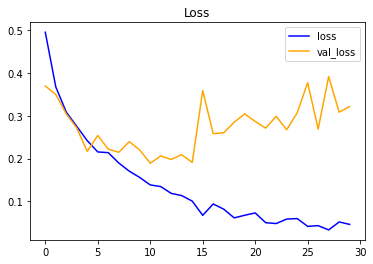

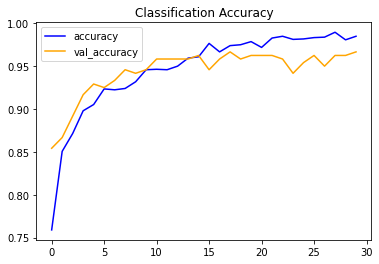

In [14]:
summarize_diagnostics(history)

In [15]:
classes = ['Tipo A_ Kunzea', 'Tipo B_ Lepto']

In [16]:
from sklearn.metrics import classification_report
def validateResults(model):   
  predictions = model.predict(x_test, batch_size=32)
  y_pred = np.argmax(predictions, axis=1) 
  y_true = np.argmax(y_test, axis=0)

  print("\n"+ classification_report(y_test, y_pred, target_names=classes))
  print(confusion_matrix(y_test, y_pred))
  confusion_mtx = confusion_matrix(y_test, y_pred)
  cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)


                precision    recall  f1-score   support

Tipo A_ Kunzea       0.94      0.97      0.95       120
 Tipo B_ Lepto       0.97      0.94      0.95       120

      accuracy                           0.95       240
     macro avg       0.95      0.95      0.95       240
  weighted avg       0.95      0.95      0.95       240

[[116   4]
 [  7 113]]


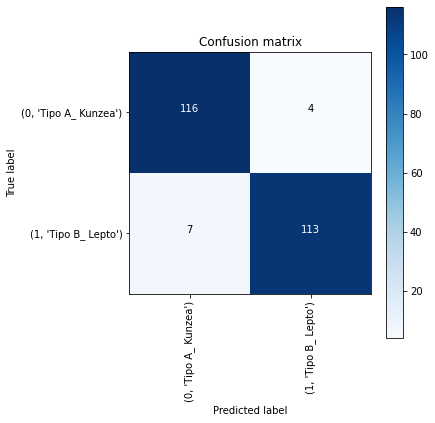

In [17]:
validateResults(model)



---



CNN v2



---



In [27]:
model2 = keras.models.Sequential([
    keras.layers.Conv2D(32, 3, activation="relu", input_shape=[100, 100, 3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, 3, activation="relu"),    
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(128, 3, activation="relu"),    
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),   
    keras.layers.Dense(2, activation="sigmoid")    
])

In [28]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 49, 49, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 23, 23, 64)       

In [29]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# fit model
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

#es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-4)

history2 = model2.fit(
      train_it, 
      steps_per_epoch=len(train_it),
      validation_data=validation_it, 
      validation_steps=len(validation_it), 
      epochs=epoch, 
      verbose=1,
      callbacks=[rlrop])

Epoch 1/30
30/30 [==============================] - 3s 57ms/step - loss: 0.5536 - accuracy: 0.7094 - val_loss: 0.4663 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/30
30/30 [==============================] - 1s 48ms/step - loss: 0.4095 - accuracy: 0.8255 - val_loss: 0.3628 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 3/30
30/30 [==============================] - 1s 48ms/step - loss: 0.3497 - accuracy: 0.8615 - val_loss: 0.3153 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 4/30
30/30 [==============================] - 1s 49ms/step - loss: 0.3287 - accuracy: 0.8776 - val_loss: 0.3128 - val_accuracy: 0.9083 - lr: 0.0010
Epoch 5/30
30/30 [==============================] - 1s 48ms/step - loss: 0.2896 - accuracy: 0.8849 - val_loss: 0.3218 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 6/30
30/30 [==============================] - 1s 48ms/step - loss: 0.2720 - accuracy: 0.8948 - val_loss: 0.2753 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 7/30
30/30 [==============================] - 1s 49ms/step - loss: 0.2

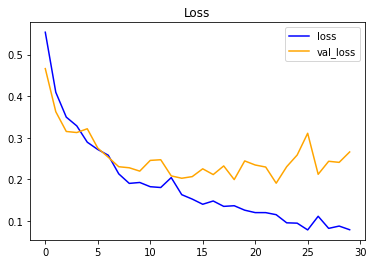

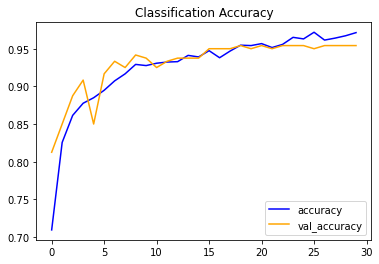

In [31]:
summarize_diagnostics(history2)


                precision    recall  f1-score   support

Tipo A_ Kunzea       0.98      0.96      0.97       120
 Tipo B_ Lepto       0.96      0.98      0.97       120

      accuracy                           0.97       240
     macro avg       0.97      0.97      0.97       240
  weighted avg       0.97      0.97      0.97       240

[[115   5]
 [  2 118]]


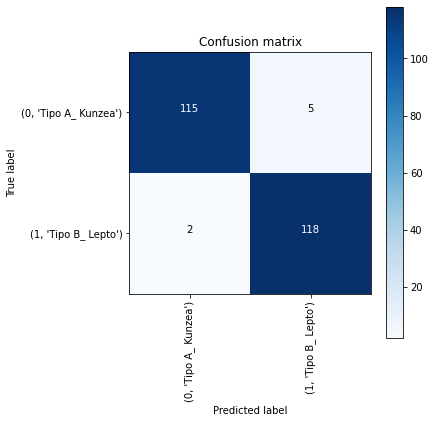

In [32]:
validateResults(model2)